# Pronostico de series de tiempo (ARIMA)

En este análisis se utiliza el conjunto de datos históricos de pasajeros mensuales de una aerolínea internacional, que abarca el periodo de enero de 1949 a diciembre de 1960. La serie representa el número total de pasajeros transportados cada mes y es una de las series temporales clásicas en el análisis estadístico. El objetivo es aplicar un modelo ARIMA (AutoRegressive Integrated Moving Average) para modelar y pronosticar la evolución futura del número de pasajeros, evaluando previamente los supuestos necesarios como la estacionariedad y utilizando herramientas estadísticas para seleccionar los parámetros más adecuados del modelo.

# 1.Cargar y visualizar los datos

La imagen muestra un gráfico de líneas que representa el número de pasajeros de aerolíneas por mes desde 1949 hasta 1960. Se puede observar una tendencia general al aumento en el número de pasajeros a lo largo de los años. Además, se aprecia un patrón estacional dentro de cada año, con picos más altos en los meses de verano y una disminución en los meses de invierno.

In [ ]:
!pip install pandas matplotlib statsmodels

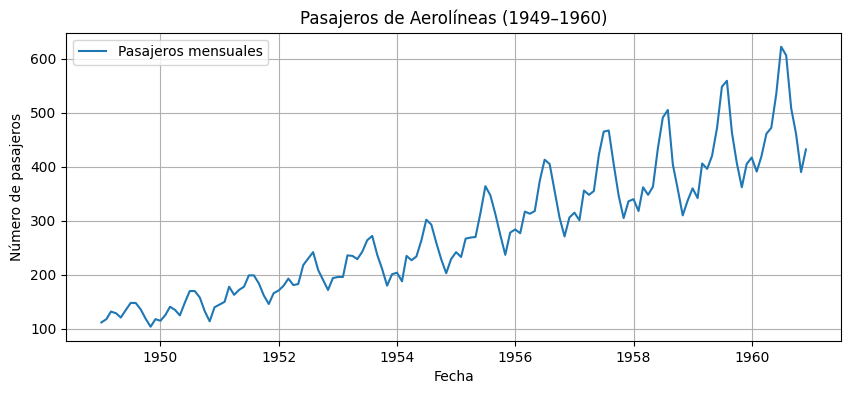

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar dataset real de pasajeros mensuales
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
df.columns = ['pasajeros']

# Visualizar la serie temporal
plt.figure(figsize=(10, 4))
plt.plot(df['pasajeros'], label='Pasajeros mensuales')
plt.title('Pasajeros de Aerolíneas (1949–1960)')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.grid(True)
plt.legend()
plt.show()


# 2 Verificar los supuestos de ARIMA


## 2.1 Estacionariedad (Dickey-Fuller)

Para saber si la serie de datos de pasajeros se puede usar directamente en un modelo ARIMA, primero aplicamos la prueba de Dickey-Fuller aumentada. Esta prueba nos dice si la serie es estacionaria, es decir, si su comportamiento no cambia mucho con el tiempo. Si el valor p de la prueba es mayor a 0.05, significa que la serie no es estacionaria y que necesitamos transformarla (por ejemplo, sacarle la diferencia) antes de usarla en un modelo. En cambio, si el valor p es menor o igual a 0.05, la serie sí es estacionaria y la podemos usar tal como está.

In [ ]:
from statsmodels.tsa.stattools import adfuller

resultado_adf = adfuller(df['pasajeros'])
print("ADF Statistic:", resultado_adf[0])
print("p-valor:", resultado_adf[1])

if resultado_adf[1] > 0.05:
    print("👉 La serie NO es estacionaria (se necesita diferenciación).")
else:
    print("✅ La serie es estacionaria.")


ADF Statistic: 0.8153688792060498
p-valor: 0.991880243437641
👉 La serie NO es estacionaria (se necesita diferenciación).


## 2.2 Visualización de autocorrelación (ACF y PACF)

Las gráficas de autocorrelación (ACF) y autocorrelación parcial (PACF) permiten visualizar qué tanto los valores pasados de la serie están relacionados con los actuales. La ACF muestra cómo la serie se correlaciona consigo misma en distintos rezagos, lo que ayuda a detectar patrones repetitivos. La PACF, por su parte, muestra la relación directa entre la serie y sus rezagos, eliminando la influencia de los rezagos intermedios. Estas visualizaciones son clave para elegir adecuadamente los parámetros del modelo ARIMA, en particular los valores de p (autorregresivo) y q (media móvil)

<Figure size 1200x400 with 0 Axes>

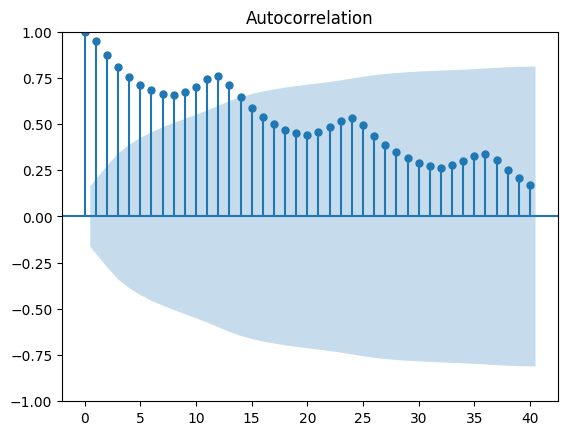

<Figure size 1200x400 with 0 Axes>

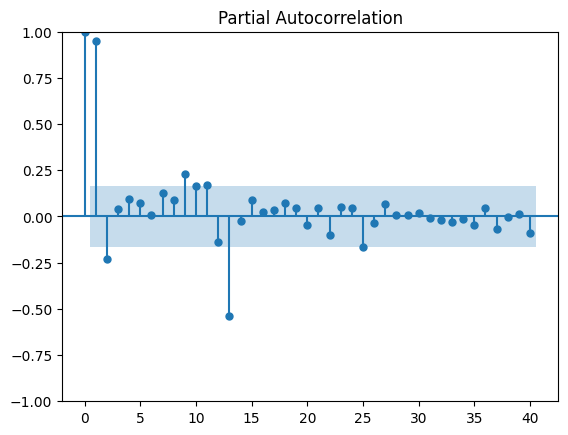

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))
plot_acf(df['pasajeros'], lags=40)
plt.show()

plt.figure(figsize=(12,4))
plot_pacf(df['pasajeros'], lags=40)
plt.show()


* **Autocorrelación:** Este gráfico de autocorrelación muestra cómo el número de pasajeros de aerolíneas en un momento dado se relaciona con el número de pasajeros en momentos anteriores. Las barras que sobresalen de la zona sombreada indican una correlación significativa. Se observa que los valores cercanos en el tiempo están fuertemente relacionados (barras altas al principio), y esta relación se repite aproximadamente cada 12 periodos, lo que sugiere un patrón estacional anual en el número de pasajeros. La disminución gradual de la altura de las barras a medida que nos alejamos en el tiempo indica que la influencia de los valores pasados disminuye, pero la persistencia de picos a intervalos regulares confirma la fuerte estacionalidad.

* **Autocorrelación parcial:** Este gráfico de autocorrelación parcial nos ayuda a entender la relación directa entre el número de pasajeros en un momento dado y el número de pasajeros en momentos anteriores, eliminando la influencia de los puntos intermedios. Las barras que se extienden más allá de la zona sombreada indican una correlación parcial significativa. Aquí vemos picos importantes en los primeros rezagos (especialmente en el rezago 1) y luego alrededor del rezago 12. Esto sugiere que el valor actual está fuertemente influenciado por el valor inmediatamente anterior y también por el valor de hace aproximadamente un año, después de tener en cuenta los efectos de los meses intermedios. La mayoría de las otras barras se encuentran dentro de la zona sombreada, lo que indica que su contribución directa es menos significativa.

## 2.3 Diferenciar la serie.

In [ ]:
df_diff = df['pasajeros'].diff().diff().dropna()

# Verificar estacionariedad tras diferenciar
resultado_adf_diff = adfuller(df_diff)
print("ADF después de diferenciar:", resultado_adf_diff[0])
print("p-valor:", resultado_adf_diff[1])


ADF después de diferenciar: -16.384231542468513
p-valor: 2.7328918500142026e-29


Luego de aplicar una doble diferenciación a la serie de pasajeros, se realizó la prueba de Dickey-Fuller aumentada (ADF) para verificar si la serie resultante es estacionaria. El resultado arrojó un estadístico ADF de -16.38 y un p-valor cercano a cero (2.73e-29), lo que indica con claridad que la serie ya no presenta tendencias ni variaciones estructurales significativas a lo largo del tiempo. En consecuencia, se confirma que la serie es estacionaria y, por tanto, adecuada para el modelado con técnicas como ARIMA.

## 2.4 Visualización de la serie diferenciada

Ahora se genera una visualización de la serie temporal después de haberle aplicado dos diferenciaciones consecutivas, lo que ayuda a estabilizar su media y eliminar tendencias. El gráfico permite observar cómo se comporta la serie transformada en el tiempo y verificar visualmente si muestra un comportamiento más estacionario. Esta representación es clave para confirmar que los pasos de preprocesamiento han sido efectivos antes de ajustar un modelo ARIMA.

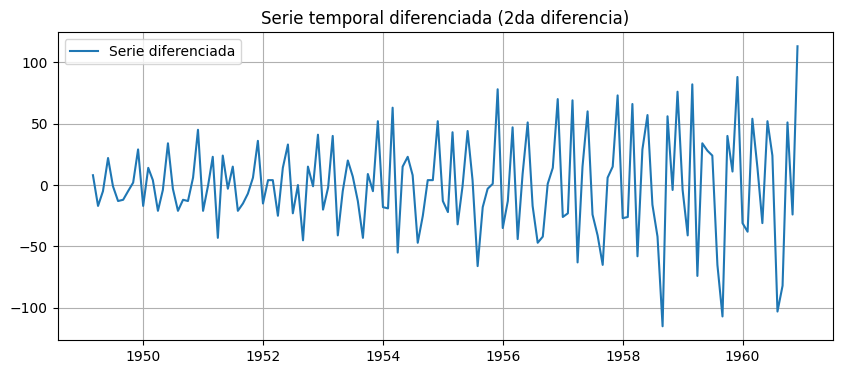

In [ ]:
plt.figure(figsize=(10, 4))
plt.plot(df_diff, label='Serie diferenciada')
plt.title('Serie temporal diferenciada (2da diferencia)')
plt.grid(True)
plt.legend()
plt.show()

# 3 Ajustar modelo ARIMA
Se ajusta el modelo ARIMA con los parámetros (2, 1, 2), lo que implica que se tomarán en cuenta los dos valores anteriores de la serie, se diferencia una vez para hacerla estacionaria, y se utilizan los dos errores pasados para mejorar la predicción.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar ARIMA(2,1,2) como ejemplo
modelo = ARIMA(df['pasajeros'], order=(2,1,2))
resultado = modelo.fit()
print(resultado.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              pasajeros   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Tue, 06 May 2025   AIC                           1353.347
Time:                        22:10:58   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.814      0.0

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


El modelo ARIMA(2,1,2) ajustado a la serie de pasajeros muestra un buen desempeño general. Los coeficientes de las partes autorregresiva (AR) y de media móvil (MA) son significativos (todos con p-valores < 0.05), lo que indica que cada uno aporta valor a la predicción. El AIC (1353.347) y BIC (1368.161) son útiles para comparar este modelo con otros, donde valores más bajos indican un mejor ajuste, y en este caso están dentro de rangos razonables. Además, el test de Ljung-Box da un p-valor alto (0.59), lo que sugiere que los residuos no están autocorrelacionados, lo cual es deseable.

Por otro lado, el modelo presenta algo de heterocedasticidad (p-valor = 0.00 en el test H), lo que significa que la varianza de los errores no es constante en toda la serie, y eso podría afectar un poco la precisión. Sin embargo, los residuos parecen seguir una distribución cercana a la normal, con una kurtosis de 3.14 (muy cerca de 3) y una asimetría leve (0.27). En resumen, es un modelo que explica bien la serie y es funcional, aunque podría mejorarse un poco si se quiere afinar más el pronóstico.

 # 4.Evaluar los residuos del modelo

4.1 Gráfico de residuos

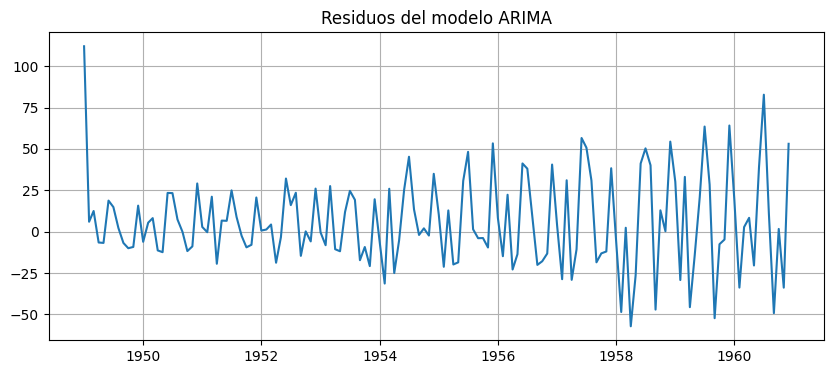

In [ ]:
residuos = resultado.resid

plt.figure(figsize=(10, 4))
plt.plot(residuos)
plt.title('Residuos del modelo ARIMA')
plt.grid(True)
plt.show()


4.2 Autocorrelación de residuos (deben parecer ruido blanco)

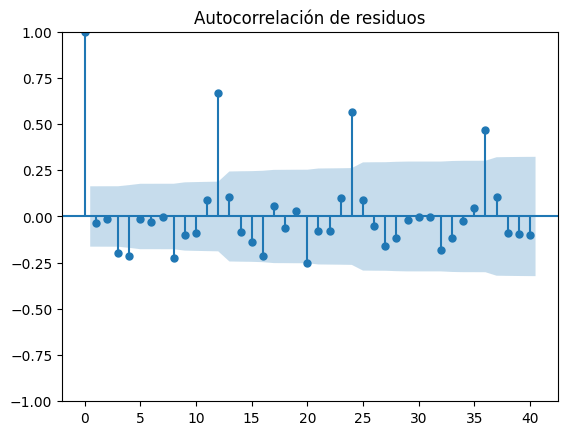

In [ ]:
plot_acf(residuos, lags=40)
plt.title("Autocorrelación de residuos")
plt.show()


El gráfico muestra la autocorrelación de los residuos del modelo ARIMA(2,1,2) y sugiere que el modelo no ha logrado capturar completamente la estructura temporal de los datos. Aunque muchos de los puntos están dentro del área azul (lo esperado si los residuos fueran ruido blanco), algunos lags como el 13, 24 y 36 presentan autocorrelaciones significativas, lo que indica que aún queda dependencia en los errores. Esto significa que el modelo podría mejorarse, ya que idealmente no debería quedar ninguna relación entre los residuos en distintos momentos del tiempo.

4.3 Prueba de Ljung-Box (residuos no autocorrelacionados)

In [ ]:
from statsmodels.stats.diagnostic import acorr_ljungbox

lb_test = acorr_ljungbox(residuos, lags=[10], return_df=True)
print(lb_test)

if lb_test['lb_pvalue'].values[0] > 0.05:
    print("✅ No hay autocorrelación significativa en los residuos.")
else:
    print("⚠️ Hay autocorrelación en los residuos.")

      lb_stat  lb_pvalue
10  24.077141   0.007398
⚠️ Hay autocorrelación en los residuos.


El valor p del test de Ljung-Box es 0.007, lo cual es menor a 0.05, indicando que sí hay autocorrelación en los residuos del modelo. Esto significa que el modelo ARIMA no está capturando completamente la estructura temporal de los datos, y todavía quedan patrones que no han sido explicados.

4.4 Normalidad de residuos (histograma y prueba de Shapiro-Wilk)

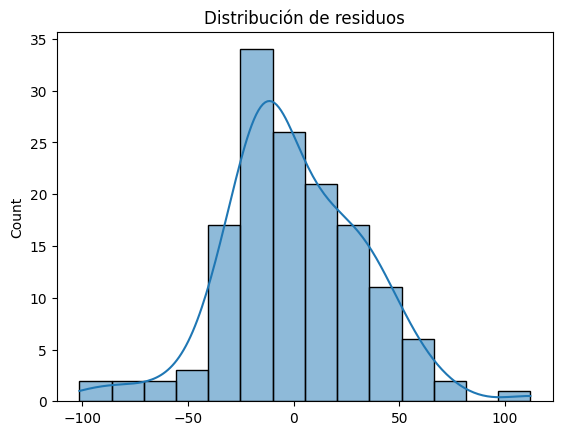

Shapiro-Wilk p-valor: 0.06495682198284028
✅ Los residuos parecen normales.


In [ ]:
import seaborn as sns
from scipy.stats import shapiro

sns.histplot(residuos, kde=True)
plt.title('Distribución de residuos')
plt.show()

stat, p = shapiro(residuos)
print("Shapiro-Wilk p-valor:", p)

if p > 0.05:
    print("✅ Los residuos parecen normales.")
else:
    print("⚠️ Los residuos NO siguen una distribución normal.")


El p-valor del test de Shapiro-Wilk es aproximadamente 0.065, que es mayor a 0.05, lo que indica que no se rechaza la normalidad. En otras palabras, los residuos del modelo parecen seguir una distribución normal, lo cual es una buen indicativo para la validez del modelo ARIMA.

# 5: Validación del modelo (predicción vs realidad)

5.1 Separar entrenamiento y prueba

In [ ]:
train = df['pasajeros'][:-12]
test = df['pasajeros'][-12:]

5.2 Ajustar modelo y pronosticar

In [ ]:
modelo_val = ARIMA(train, order=(2,1,2))
resultado_val = modelo_val.fit()
pred = resultado_val.forecast(steps=12)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


5.3 Métricas de evaluación

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, pred)
rmse = np.sqrt(mean_squared_error(test, pred))
mape = np.mean(np.abs((test - pred) / test)) * 100

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 41.83
RMSE: 55.22
MAPE: 8.22%


Las métricas de evaluación del modelo ARIMA nos ayudan a entender qué tan buenas son sus predicciones.

* El MAE (Error Absoluto Medio) fue de aproximadamente 41.83 pasajeros, lo que significa que, en promedio, las predicciones se desvían de los valores reales por unos 42 pasajeros.

* El RMSE (Raíz del Error Cuadrático Medio) fue de 55.22, lo que indica que los errores más grandes tienen un mayor impacto en la evaluación del modelo.

* El MAPE (Error Porcentual Absoluto Medio) fue de 8.22%, lo que es un valor bajo y sugiere que el modelo tiene un buen nivel de precisión, ya que, en promedio, el error de predicción representa solo un 8.22% del valor real. En conjunto, estos resultados muestran que el modelo logra capturar bien el comportamiento de la serie temporal.

5.4 Visualizar predicción vs valores reales

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from statsmodels.tsa.arima.model import ARIMA
from IPython.display import HTML
import warnings
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Configuración para evitar figuras adicionales
plt.ioff()  # Desactiva el modo interactivo

# Configuración de warnings
warnings.filterwarnings("ignore", category=UserWarning, module='statsmodels')

# 1. Cargar los datos
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url, parse_dates=['Month'], index_col='Month')
series = df['Passengers']

# 2. Preparar la figura para la animación
fig, ax = plt.subplots(figsize=(10, 8))
plt.close()  # Cierra la figura estática para que no aparezca

# Configuración del gráfico
ax.set_title('Animación del Modelo ARIMA - Pasajeros de Aerolíneas')
ax.set_xlabel('Año')
ax.set_ylabel('Número de Pasajeros')
ax.grid(True)

# Dividir los datos
train_size = int(len(series) * 0.8)
train, test = series[:train_size], series[train_size:]

# Inicializar variables
history = [x for x in train]
predictions = []
actuals = []
dates = []
mae_values = []
rmse_values = []
mape_values = []

# 3. Función para calcular métricas
def calculate_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mae, rmse, mape

# 4. Función de animación
def animate(i):
    ax.clear()

    try:
        # Entrenar modelo
        model = ARIMA(history, order=(2,1,1))
        model_fit = model.fit()

        # Predecir siguiente punto
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)

        # Registrar valor real
        if i < len(test):
            actual = test.iloc[i]
            actuals.append(actual)
            history.append(actual)
            dates.append(test.index[i])

        # Gráfico principal
        ax.plot(series, label='Datos reales')
        if len(predictions) > 0:
            ax.plot(dates, predictions, color='red', marker='o', label='Predicciones')
            ax.scatter(dates[-1], predictions[-1], color='darkred', s=100)

        ax.axvline(x=train.index[-1], color='gray', linestyle='--')
        ax.grid(True)
        ax.set_title(f'Modelo ARIMA(2,1,1) - Paso {i+1}/{len(test)}')

        # Calcular y mostrar métricas si hay datos suficientes
        if len(actuals) > 0:
            mae, rmse, mape = calculate_metrics(actuals, predictions)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mape_values.append(mape)

            # Mostrar métricas en el gráfico
            textstr = f'Métricas actuales:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nMAPE: {mape:.2f}%'
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
            ax.text(0.02, 0.98, textstr, transform=ax.transAxes,
                   verticalalignment='top', bbox=props)

        ax.legend()

        # Detener animación al final
        if i >= len(test)-1:
            ani.event_source.stop()

    except Exception as e:
        print(f"Error en paso {i}: {str(e)}")
        ani.event_source.stop()

# 5. Crear animación
ani = FuncAnimation(fig, animate, frames=len(test), interval=800, repeat=False)

# Generar el HTML
html_content = ani.to_jshtml()

# Guardar el HTML en un archivo
with open('arima_animation.html', 'w') as f:
    f.write(html_content)


# Mostrar solo la animación
HTML(ani.to_jshtml())

# 6. Conclusiones

En resumen, el modelo ARIMA(2,1,2) muestra un buen ajuste a los datos de la serie temporal de pasajeros. A pesar de que los residuos no presentan autocorrelación significativa, lo que indica que el modelo ha capturado adecuadamente la estructura temporal, algunos de los coeficientes de las componentes AR (autoregresiva) y MA (media móvil) no son significativos, lo que sugiere que podría haber margen para mejorar el modelo. Sin embargo, las métricas de evaluación como el MAE, RMSE y MAPE indican que las predicciones son relativamente precisas, con un error promedio bajo y un buen nivel de ajuste. En general, el modelo proporciona una predicción confiable de la serie temporal, aunque podría explorarse la posibilidad de probar con diferentes combinaciones de parámetros para mejorar el rendimiento.